# Simple regression

In [1]:
import jax
import jax.numpy as jnp
from pcv.inference import run_cv_sel
from pcv.plots import plot_model_results, plot_fold_results
from pcv.models import reg
from pcv.rules import make_positive_rule, make_positive_negative_rule
import matplotlib.pyplot as plt

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Model definition

Gaussian linear regression, with an outlier injected into the data

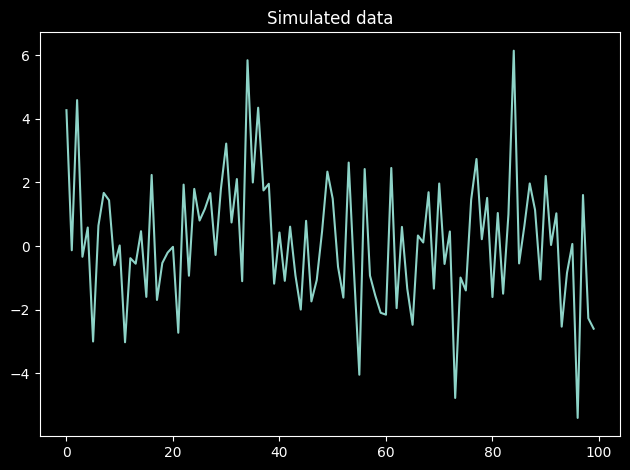

In [2]:
y, X = reg.generate(
    key=jax.random.PRNGKey(0),
    N = 100,
    beta0 = jnp.array([1.0, 1.0, 1.0, 0.5]),
    sigsq0 = jnp.array(2.0))

plt.plot(y)
plt.title('Simulated data')
plt.tight_layout()

In [3]:
K = 10
logjoint_density, log_pred, make_initial_pos = reg.get_model(y, X, K=K)

## Inference


In [4]:
inference_key = jax.random.PRNGKey(43)
results = run_cv_sel(
       prng_key=inference_key,
       logjoint_density=logjoint_density,
       log_p=log_pred,
       make_initial_pos=make_initial_pos,
       stoprule=make_positive_negative_rule(num_folds=K, level=0.95),
       num_folds=K,
       num_chains=4,
       batch_size=100,
       warmup_iter=1000,
       max_batches=50,
       ignore_stoprule=True
)

MEADS warmup for 10 folds per model (80 chains)...
Completed 80000 warmup iterations in 6 seconds
Starting cross-validation with 80 parallel GHMC chains...
Triggered stoprule after 7 batches in 17 seconds
Drew 400000 iterations in 115.0 seconds (3477 i/s)


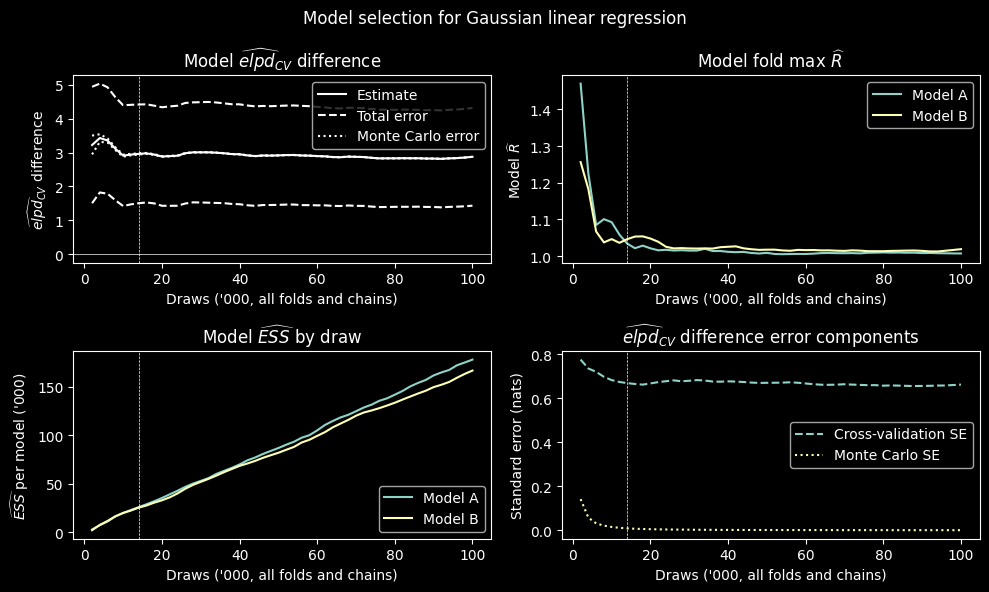

In [5]:
plot_model_results(results, title="Model selection for Gaussian linear regression")

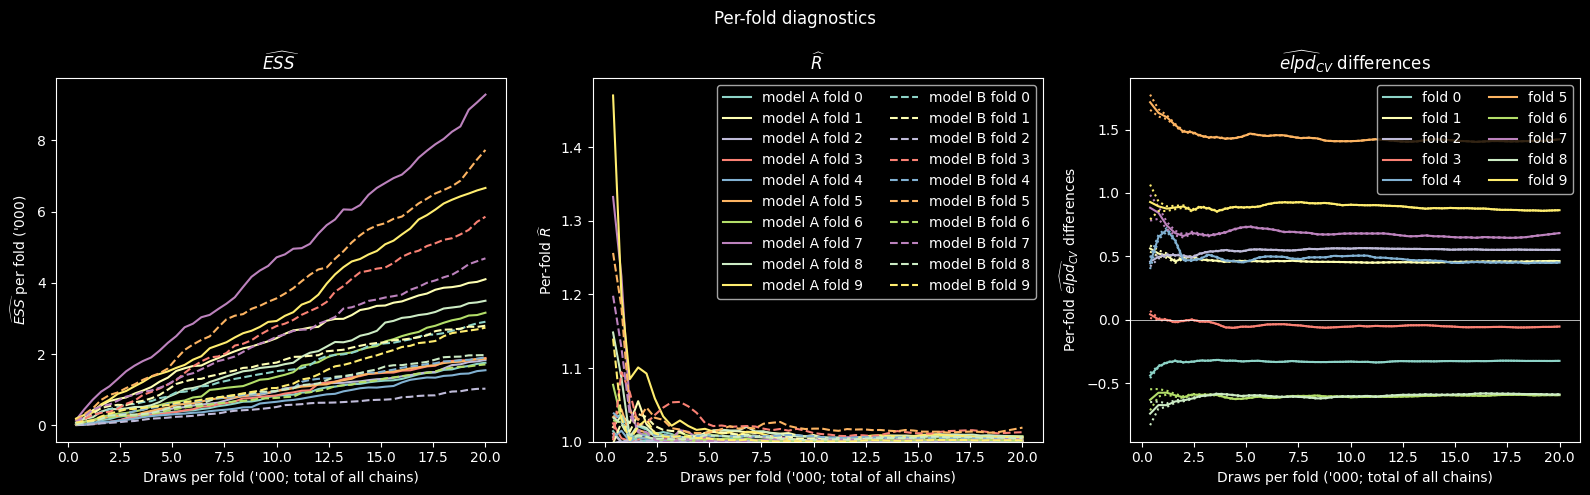

In [6]:
plot_fold_results(results, title='Per-fold diagnostics')